# Feature Engineering for Churn Detection

## Imports and Settings

In [1]:
# Helper libraries
import warnings

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.evaluation import display_clf_report, validate_model_with_cv
from churn_detection.features import ColumnPreprocessor, Transformation, engineer_features, create_pipe


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

## Feature Engineering Strategies

### Interaction Features

Let's create interaction terms between important categorical features.

In [4]:
# Example with internetservice and onlinesecurity
cat_var_1 = "internetservice"
cat_var_2 = "onlinesecurity"
new_feature = "intser_onsec_strength"

interaction_strength = (
    preprocessed_data.groupby([cat_var_1, cat_var_2])["churn"]
    .mean()
    .reset_index()
)
interaction_strength.rename(columns={"churn": new_feature}, inplace=True)
interaction_strength.sort_values(by=new_feature, ascending=False)

,internetservice,onlinesecurity,intser_onsec_strength
2,fiber_optic,no,0.4936
0,dsl,no,0.2796
3,fiber_optic,yes,0.2181
1,dsl,yes,0.0949
4,no,no_internet_service,0.0740


Let's encode as ordinal numbers the resulting strength labels.

In [5]:
interaction_strength.intser_onsec_strength.loc[0:5] = [0, 1, 2, 3, 5]
interaction_strength.intser_onsec_strength = interaction_strength.intser_onsec_strength.astype("int32")

In [6]:
# Merge the interaction strength back into initial dataset
new_preprocessed_data = preprocessed_data.merge(
    interaction_strength, on=[cat_var_1, cat_var_2], how="left"
)

In [7]:
from churn_detection.visualization import plot_stem

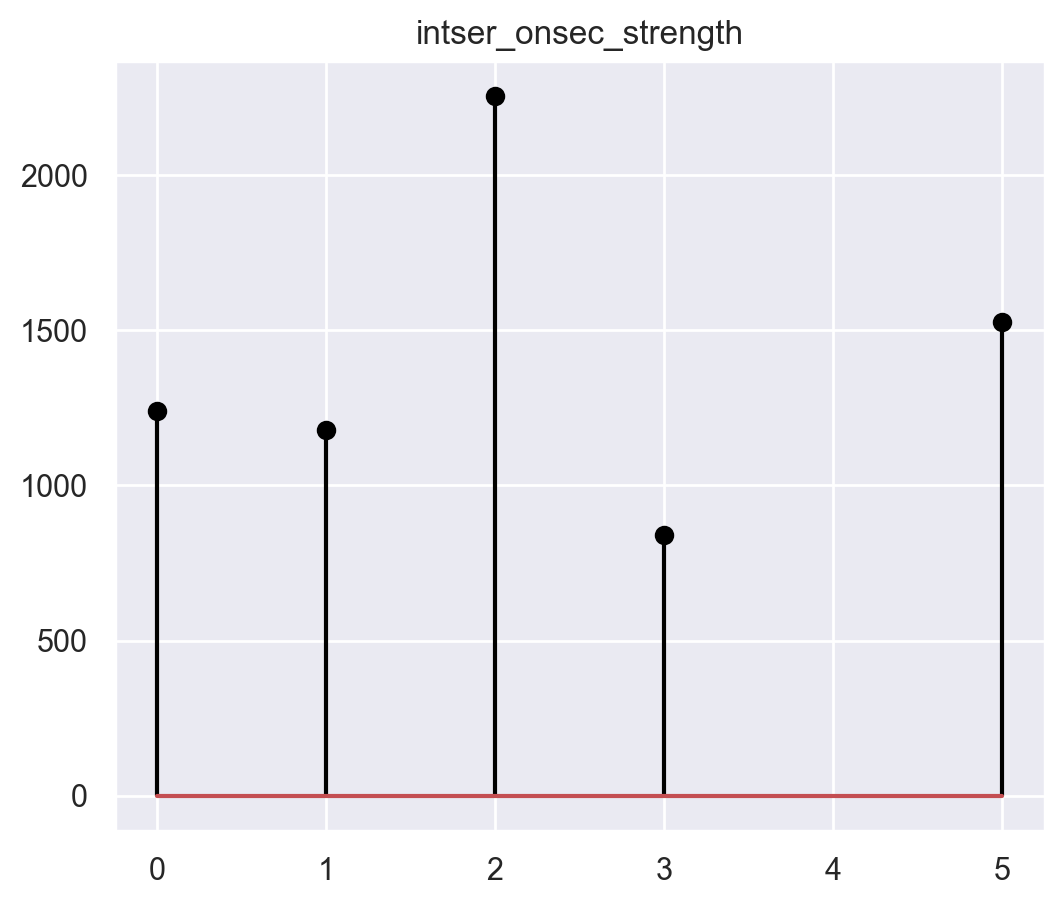

In [8]:
plot_stem(new_preprocessed_data, new_feature, size=(6,5))

## Model Training and Testing

### Final Pipeline Setting

In [9]:
# We can append the new feature into numeric feature set

In [10]:
multimodal_set = numeric_variables[:-1] + [new_feature]
skewed_set = ["totalcharges"] 
discrete_set = categorical_variables

In [11]:
MULTIMODAL_FEATURES = {
    "name": "multimod", "variables": multimodal_set,
    "steps": [("stdscaler", StandardScaler())],
}

SKEWED_FEATURES = {
    "name": "skewed", "variables": skewed_set,
    "steps": [("robustscaler", RobustScaler(quantile_range=(40, 60)))],
}

DISCRETE_FEATURES = {
    "name": "discrete", "variables": discrete_set,
    "steps": [("catencoder", OneHotEncoder(drop="if_binary", sparse_output=False))],
}

In [12]:
pipeline = ColumnPreprocessor()

pipeline.add_transformation(
    Transformation(**MULTIMODAL_FEATURES)
)

pipeline.add_transformation(
    Transformation(**SKEWED_FEATURES)
)

pipeline.add_transformation(
    Transformation(**DISCRETE_FEATURES)
)

In [13]:
prep_train, prep_test = train_test_split(
    new_preprocessed_data, 
    test_size=0.2, 
    random_state=1
)

In [14]:
X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [15]:
preprocessor = pipeline.create_preprocessor()
model = LogisticRegression(random_state=0)

lr_pipe = create_pipe(
    preprocessor, 
    LogisticRegression(random_state=0)
)

In [16]:
mean, var = validate_model_with_cv(lr_pipe, train_data=(X_train, y_train), metric="roc_auc")
print(f"ROC AUC score with default threshold: Mean = {mean:.4f}, Var = {var:.4f}")

ROC AUC score with default threshold: Mean = 0.8425, Var = 0.0168


### Final Score on Test Data

In [17]:
transformers = pipeline.get_transformations()
train_features = engineer_features(X_train, transformers)
model.fit(train_features, y_train)

LogisticRegression(random_state=0)

In [18]:
# Test Data
test_features = engineer_features(X_test, transformers)
test_predictions = model.predict(test_features)
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1061
           1       0.63      0.60      0.61       348

    accuracy                           0.81      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.81      0.81      0.81      1409



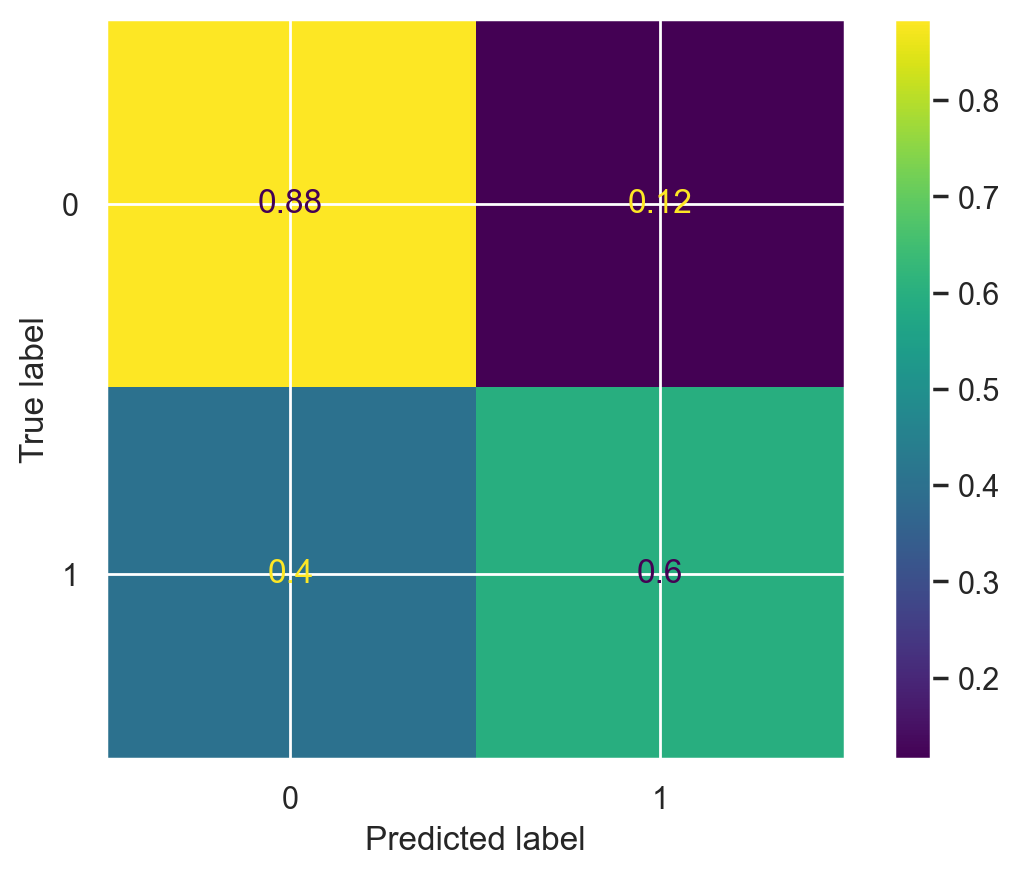

In [19]:
# Test Set
plot_confusion_table(y_test, test_predictions)

This settings is equivalent to logistic regression v4.<br>
This strategy doesn't improve the previous iteration by combining internetservice and onlinesecurity.<br>
Thus we should explore all possible combinations of features. <br>